<a href="https://colab.research.google.com/github/kutouxiyiji/test1/blob/master/KNN_opendoor_YongWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset has 4 coloumns (LON, LAT, close date, close price). The close date is important to avoid the time-lekeagy. Before, I jump into the detialed questoins. I want to check the data itself. Let's visuilize the other 3 features first, which are LON, LAT and price. 



In [0]:
#import package
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

Here I upload the data to Private repositorites on Github, so Colab can load the data. I choose the repositorities as private and the data won't be on public. 





---
quick look of the data
---

---





In [2]:
#load data to df

data_url = 'https://raw.githubusercontent.com/kutouxiyiji/KNN_opendoor/master/data.csv?token=AHHTYXTM4NBVTFAA277LPAK44GE46'
df = pd.read_csv(data_url)
print(df.head())

    latitude  longitude                  close_date   close_price
0   1.501986  86.350685  2014-08-16 22:25:31.925431  1.302246e+06
1  36.367095 -98.664280  2014-08-05 06:34:00.165876  1.475045e+05
2  36.599284 -97.924700  2014-08-12 23:48:00.887510  1.374006e+05
3  67.994791  64.688589  2014-08-17 05:27:01.404296 -1.411200e+04
4  36.647982 -97.866100  2014-08-09 04:00:40.358242  2.391053e+05


Map is the earth size!

In [3]:
df.describe()

,latitude,longitude,close_price
count,88042.000000,88042.000000,8.804200e+04
mean,34.559745,-93.470194,2.663684e+06
std,13.983900,31.194818,1.543381e+07
min,-89.938989,-179.891580,-9.995300e+04
25%,36.200312,-98.481499,1.233064e+05
50%,36.385215,-98.165490,1.816143e+05
75%,36.544719,-97.967260,2.841568e+05
max,89.984841,179.969440,1.009998e+08


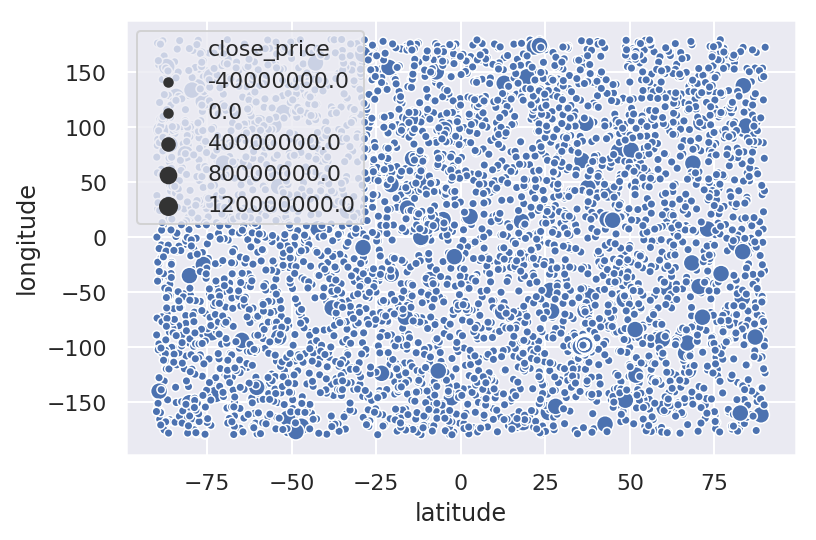

In [4]:
ax = sns.scatterplot( x='latitude', y='longitude', size = 'close_price', data=df)

In [5]:
len(df[df['close_price']>100000000]) , len(df), len(df[df['close_price']<0])

(2137, 88042, 2174)

The data looks like is synthetic and not very helpful from the simple visualization. 

---

Let us jump to KNN then. 



---

Naive KNN
---

In [6]:
# use df1 to store the data where the price is larger than 0....
df1 = df[df['close_price']>0]
df1.describe()

,latitude,longitude,close_price
count,85868.000000,85868.000000,8.586800e+04
mean,34.561816,-93.481662,2.732370e+06
std,13.969011,31.145552,1.562185e+07
min,-89.938989,-179.891580,5.791186e+02
25%,36.200321,-98.481290,1.274550e+05
50%,36.385278,-98.165540,1.849756e+05
75%,36.544679,-97.966945,2.883876e+05
max,89.984841,179.969440,1.009998e+08


Regarding the time leakage: it is very important for this model. If we use all the data to fit the model, we will get unreal larger data (data from 'future'). This will cause the overfitting.

---

However, the time leakage will cause additional complexity for the model. For the intial try, I would like to start with **a KNN regression without time leakage feature**. And see how it works. 

In [27]:
df1.head()

,latitude,longitude,close_date,close_price
0,1.501986,86.350685,2014-08-16 22:25:31.925431,1.302246e+06
1,36.367095,-98.664280,2014-08-05 06:34:00.165876,1.475045e+05
2,36.599284,-97.924700,2014-08-12 23:48:00.887510,1.374006e+05
4,36.647982,-97.866100,2014-08-09 04:00:40.358242,2.391053e+05
5,36.525885,-98.333570,2014-08-07 15:18:18.456538,2.708852e+05


In [7]:
# convert the close date from string to number
df1['close_date'][0:10],  type(df1['close_date'][0])

(0     2014-08-16 22:25:31.925431
 1     2014-08-05 06:34:00.165876
 2     2014-08-12 23:48:00.887510
 4     2014-08-09 04:00:40.358242
 5     2014-08-07 15:18:18.456538
 6     2014-07-02 05:52:19.916181
 7     2014-06-24 14:25:57.049269
 8     2014-06-14 19:50:34.953236
 9     2014-08-12 22:53:49.559967
 10    2014-06-23 12:00:30.719576
 Name: close_date, dtype: object, str)

In [8]:
close_dates = []
for date in df1['close_date']:
  temp = datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')
  close_dates.append([float(temp.year), float(temp.month), float(temp.day), float(temp.hour), float(temp.minute), float(temp.second), float(temp.microsecond)])
close_dates[0:10]

[[2014.0, 8.0, 16.0, 22.0, 25.0, 31.0, 925431.0],
 [2014.0, 8.0, 5.0, 6.0, 34.0, 0.0, 165876.0],
 [2014.0, 8.0, 12.0, 23.0, 48.0, 0.0, 887510.0],
 [2014.0, 8.0, 9.0, 4.0, 0.0, 40.0, 358242.0],
 [2014.0, 8.0, 7.0, 15.0, 18.0, 18.0, 456538.0],
 [2014.0, 7.0, 2.0, 5.0, 52.0, 19.0, 916181.0],
 [2014.0, 6.0, 24.0, 14.0, 25.0, 57.0, 49269.0],
 [2014.0, 6.0, 14.0, 19.0, 50.0, 34.0, 953236.0],
 [2014.0, 8.0, 12.0, 22.0, 53.0, 49.0, 559967.0],
 [2014.0, 6.0, 23.0, 12.0, 0.0, 30.0, 719576.0]]

In [9]:
headers = ['year','month','day','hour','minute','second','microsecond']
df1_date = pd.DataFrame(close_dates, columns=headers)
df1_date.head()

,year,month,day,hour,minute,second,microsecond
0,2014.0,8.0,16.0,22.0,25.0,31.0,925431.0
1,2014.0,8.0,5.0,6.0,34.0,0.0,165876.0
2,2014.0,8.0,12.0,23.0,48.0,0.0,887510.0
3,2014.0,8.0,9.0,4.0,0.0,40.0,358242.0
4,2014.0,8.0,7.0,15.0,18.0,18.0,456538.0


In [10]:
df2 = pd.merge(df1, df1_date, left_index=True, right_index=True)
df2.head()

,latitude,longitude,close_date,close_price,year,month,day,hour,minute,second,microsecond
0,1.501986,86.350685,2014-08-16 22:25:31.925431,1.302246e+06,2014.0,8.0,16.0,22.0,25.0,31.0,925431.0
1,36.367095,-98.664280,2014-08-05 06:34:00.165876,1.475045e+05,2014.0,8.0,5.0,6.0,34.0,0.0,165876.0
2,36.599284,-97.924700,2014-08-12 23:48:00.887510,1.374006e+05,2014.0,8.0,12.0,23.0,48.0,0.0,887510.0
4,36.647982,-97.866100,2014-08-09 04:00:40.358242,2.391053e+05,2014.0,8.0,7.0,15.0,18.0,18.0,456538.0
5,36.525885,-98.333570,2014-08-07 15:18:18.456538,2.708852e+05,2014.0,7.0,2.0,5.0,52.0,19.0,916181.0


In [0]:
df2_X = df2[['latitude','longitude','year','month','day','hour','minute','second','microsecond']]
df2_y = df2['close_price']
X = df2_X.values
y = df2_y.values

In [0]:
t_ratio = 0.25 # test, traing ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = t_ratio)

In [13]:
knn = KNeighborsRegressor(n_neighbors=10) # 10 is a try here
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [14]:
y_pred = knn.predict(X_test)
print(y_pred[:10])

[10276986.85437174   243364.10314637 10224874.14470736   161941.298656
 10282563.03553781 10253410.15977772 20257966.23949606   186541.3160655
   234508.78551481   305249.35059425]


In [15]:
accuracy = np.median(np.abs(y_pred - y_test) / y_test)
error = np.sqrt(mean_squared_error(y_test,y_pred))
accuracy, error

(0.6795215259984531, 16092951.716059407)

In [0]:
accuracies = []
errors = []
for k in range(1,100):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracies.append(np.median(np.abs(y_pred - y_test) / y_test))
  errors.append(np.sqrt(mean_squared_error(y_test,y_pred)))
 

Text(0, 0.5, 'MRAE accuracy')

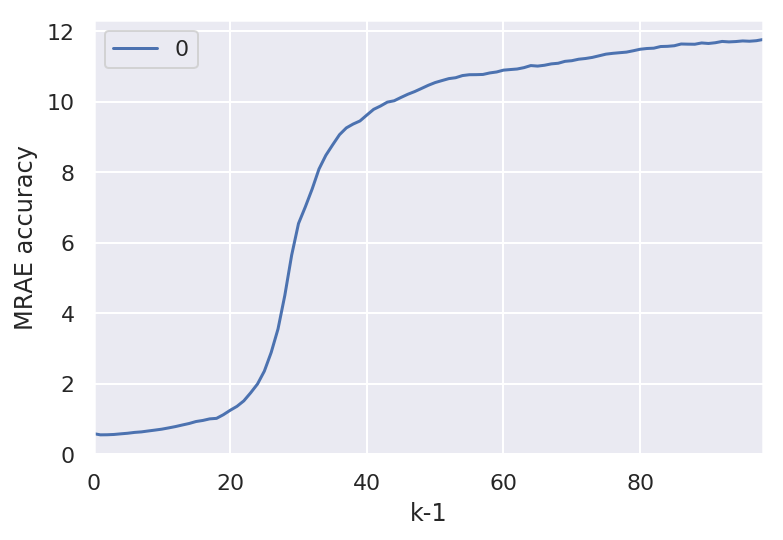

In [17]:
curve1 = pd.DataFrame(accuracies) #elbow curve 
curve1.plot()
plt.xlabel('k-1')
plt.ylabel('MRAE accuracy')

Text(0, 0.5, 'MSE')

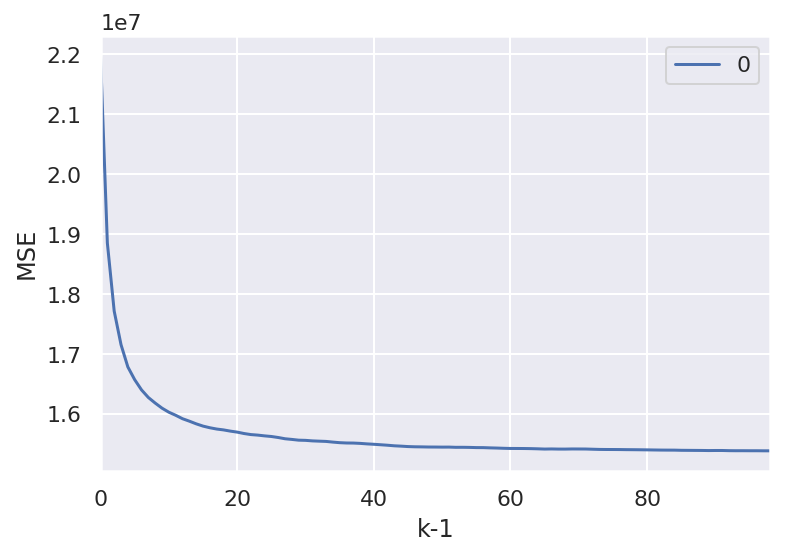

In [18]:
curve2 = pd.DataFrame(errors) #elbow curve 
curve2.plot()
plt.xlabel('k-1')
plt.ylabel('MSE')

As a conclusion for now, 1. MRAE is a better metric; 2. The navie KNN is not good. 

---

Own KNN - close look into the data
---

---

**Here we build our own KNN. The gap is 1. how to define the k nearest neighbors; 2. how to define the weight**

During the KNN process for training point X, we can easily **avoid the timeleakage**: don't use the close date after the close date of X. 

First, we will try to define the KNN. Physical distance is easy, we can use the sqrt((delta LON)^2 + (delta LAT)^2). Beacause the price of houses is a function of time also, we can mutiple the physical distance by 'time distance'. 

we want the function of time is some kind of function <1 and smaller delta time will more close to 1. Let's first look at the relation of time and price. 


In [0]:
df2.describe()


,latitude,longitude,close_price,year,month,day,hour,minute,second,microsecond
count,83742.000000,83742.000000,8.374200e+04,83742.000000,83742.000000,83742.000000,83742.000000,83742.000000,83742.000000,83742.000000
mean,34.559343,-93.461948,2.718018e+06,2014.160887,6.694502,16.154128,11.480070,29.455196,29.460104,499275.759738
std,13.983527,31.203507,1.557778e+07,0.367591,3.166680,8.899378,6.914484,17.341475,17.314474,288858.516724
min,-89.938989,-179.891580,5.791186e+02,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,12.000000
25%,36.201444,-98.479988,1.277555e+05,2014.000000,4.000000,8.000000,5.000000,14.000000,14.000000,248694.500000
50%,36.386122,-98.165720,1.852138e+05,2014.000000,7.000000,17.000000,11.000000,29.000000,29.000000,499066.500000
75%,36.544818,-97.967397,2.883182e+05,2014.000000,9.000000,24.000000,17.000000,45.000000,44.000000,749293.000000
max,89.984841,179.969440,1.009998e+08,2016.000000,12.000000,31.000000,23.000000,59.000000,59.000000,999997.000000


In [0]:
df2.head()

,latitude,longitude,close_date,close_price,year,month,day,hour,minute,second,microsecond
0,1.501986,86.350685,2014-08-16 22:25:31.925431,1.302246e+06,2014.0,8.0,16.0,22.0,25.0,31.0,925431.0
1,36.367095,-98.664280,2014-08-05 06:34:00.165876,1.475045e+05,2014.0,8.0,5.0,6.0,34.0,0.0,165876.0
2,36.599284,-97.924700,2014-08-12 23:48:00.887510,1.374006e+05,2014.0,8.0,12.0,23.0,48.0,0.0,887510.0
4,36.647982,-97.866100,2014-08-09 04:00:40.358242,2.391053e+05,2014.0,8.0,7.0,15.0,18.0,18.0,456538.0
5,36.525885,-98.333570,2014-08-07 15:18:18.456538,2.708852e+05,2014.0,7.0,2.0,5.0,52.0,19.0,916181.0


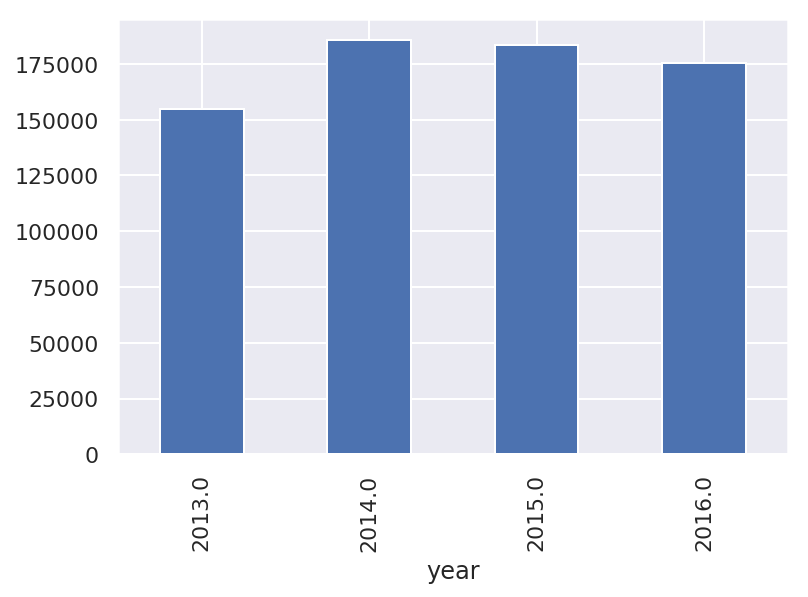

In [0]:
#overrall data year trend
df2.groupby('year')['close_price'].median().plot(kind='bar')

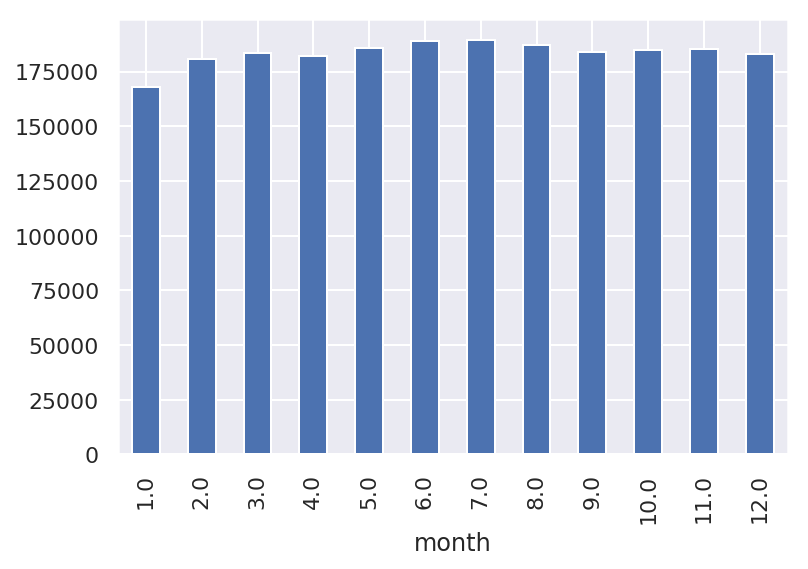

In [0]:
# most data is in year 2014. Month trend overall
df2[df2['year']==2014].groupby('month')['close_price'].median().plot(kind = 'bar')

42


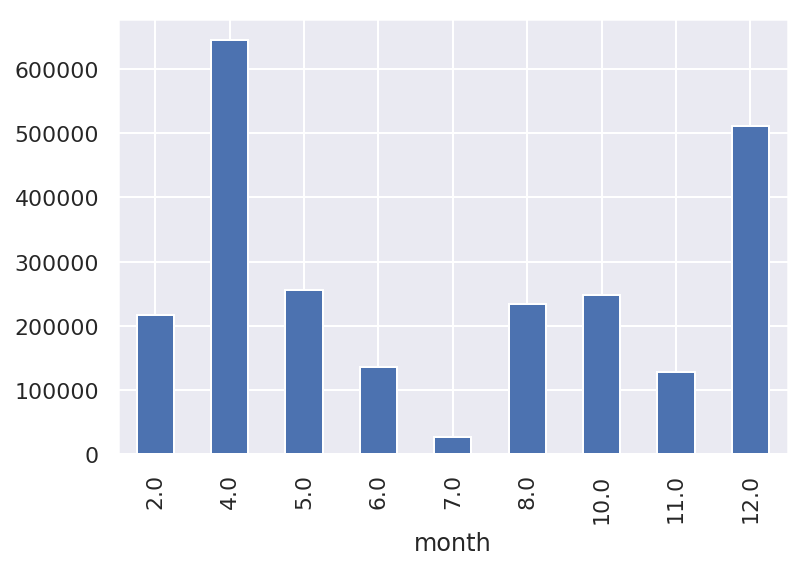

In [0]:
#let's confirm one more time, there is no time trend
df2_test1 = df2[(df2['latitude']<50) &(df2['latitude']>20) & (df2['longitude']>-140) & (df2['longitude']<-110)]
#df2_test1[df2_test1['year']==2014].groupby('month')['close_price'].median().plot(kind = 'bar')
df2_test2 = df2_test1[(df2_test1['year']==2014) &(df2_test1['close_price']<5000000)]
df2_test2.groupby('month')['close_price'].mean().plot(kind = 'bar')
print(len(df2_test2))

**No Time Pattern.**


---

KNN Model 1
---
focus on the physical distance.

---





The idea is no need to fit the data. For every sample x (we need predict), we find the k nearest neighbours in distance. Weight is 1/distance and we normalize it by devide the sum of (1/distance). The predicted price is sum(w*p). 

In [0]:
def datediff_valid(x_train,x): # x_train date < x date. 
  x_train_date = datetime(int(x_train[2]), int(x_train[3]), int(x_train[4]), int(x_train[5]), int(x_train[6]), int(x_train[7]))
  x_date = datetime(int(x[2]), int(x[3]), int(x[4]), int(x[5]), int(x[6]), int(x[7]))
  return(x_train_date<x_date)

In [0]:
def distance(p1,p2):
  return(np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
distance([1,2],[2,3])

1.4142135623730951

In [0]:
def model1_single_KNN(X_train,x,k): # k is the parameter, x is the sample
  KNN_index  = []
  weights = []
  for i in range(len(X_train)):
    if datediff_valid(X_train[i],x):  # valid, no time leakage
      d = distance(X_train[i],x)
      if d==0:
        weight = 0
      else:
        weight = 1/d
      if len(KNN_index)<k:
        KNN_index.append(i)
        weights.append(weight)
      elif weight > min(weights):
        index = weights.index(min(weights))
        weights.pop(index)
        KNN_index.pop(index)
        KNN_index.append(i)
        weights.append(weight)
  return(KNN_index, weights)



        
      
        

In [0]:
def model1_predict_helper(x, KNN_index, weights, y_train):  # predict one house
    if len(KNN_index) == 0:
      return(np.mean(y_train))
    elif np.sum(weights)==0:
      return(np.mean(y_train))
    else:
      return(np.sum(weights * y_train[KNN_index]) / np.sum(weights))


In [0]:
def model1_KNN_predict(X_train,y_train,X_test,k):
  y_pred = []
  for i in range(len(X_test)):
    x = X_test[i]
    KNN_index, weights = model1_single_KNN(X_train,x,k)
    if model1_predict_helper(x, KNN_index, weights, y_train):
      y_pred.append(model1_predict_helper(x, KNN_index, weights, y_train))
    else:
      y_pred.append(np.mean(y_train))
  return(y_pred)

In [0]:
df2_X = df2[['latitude','longitude','year','month','day','hour','minute','second','microsecond']][:4000]
df2_y = df2['close_price'][:4000]

#df2_X = df2[['latitude','longitude','year','month','day','hour','minute','second','microsecond']]
#df2_y = df2['close_price']
X = df2_X.values
y = df2_y.values

In [0]:
t_ratio = 0.25 # test, traing ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = t_ratio)

set k=4 and test the KNN model1. **The MRAE is 0.286**

In [0]:
k=4

In [0]:
y_pred = model1_KNN_predict(X_train,y_train,X_test,k)

In [0]:
MRAE = np.median(np.abs(y_pred - y_test) / y_test)
MRAE

0.2857763885978495

---
Model 2 KNN
---
The first model is super calculation heavy. We can use the KNearestRegressor from sklearn and update the train set every time to improve the efficiency. This function also has bulid-in distance. 

In [19]:
df1['close_date'][:10]

0     2014-08-16 22:25:31.925431
1     2014-08-05 06:34:00.165876
2     2014-08-12 23:48:00.887510
4     2014-08-09 04:00:40.358242
5     2014-08-07 15:18:18.456538
6     2014-07-02 05:52:19.916181
7     2014-06-24 14:25:57.049269
8     2014-06-14 19:50:34.953236
9     2014-08-12 22:53:49.559967
10    2014-06-23 12:00:30.719576
Name: close_date, dtype: object

In [20]:
df1['close_date'][1] < df1['close_date'][2]

True

in model 1, we conver the 'close_date'... now looks like it can be used directly...

In [0]:
class Model_2_KNN(BaseEstimator):
  def __init__(self, k =4, weights = 'distance',p=2):
    self.k = k
    self.weights = weights
    self.p = p
    
    
  def fit(self,X_train,y_train):
    self.X_train = X
    self.y_train = y
 

  def predict(self,X_test):
    knn = KNeighborsRegressor(self.k, p=self.p, weights=self.weights)
    y_pred = []
    for i in range(len(X_test)):
      date_i = X_test[i][2]
      index = [idx for idx, sample in enumerate(self.X_train) if sample[2]<date_i]
      #update train
      X_train_i = self.X_train[index]
      y_train_i = self.y_train[index]
      if len(X_train_i) <self.k: #first time to see
        y_pred.append(np.mean(self.y_train))
      else:
        if len(self.y_train) < self.k:
          knn.n_neighbors = len(self.y_train)
        knn.fit(X_train_i[:, :2], y_train_i)
        y_pred.append(knn.predict([X_test[i][:2]]).item())
    return(y_pred)
    
    
  def score(self, X, y):
    return np.median(np.abs(self.predict(X)-y)/y)
  

In [0]:
#test 
#df1_X = df1[['latitude','longitude','close_date']][:10000]
#df1_y = df1['close_price'][:10000]

#full data
df1_X = df1[['latitude','longitude','close_date']]
df1_y = df1['close_price']

X = df1_X.values
y = df1_y.values

In [0]:
t_ratio = 0.25 # test, traing ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = t_ratio)

In [0]:
knn = Model_2_KNN(k =4, weights = 'distance',p=2)
knn.fit(X_train,y_train)

In [0]:
y_pred = knn.predict(X_test)

In [26]:
MRAE = np.median(np.abs(y_pred - y_test) / y_test)
MRAE

0.19646827131576683

**MRAE is 0.19**

---
Find the optimal K based on Model 2. 
---


We use typical gridsearch to find the Optimal K. We limit the data to one year to reduce the calculation. 

In [0]:
# fix to a small data
df_CV = df2[df2['year'] == 2015]
df_CV_X = df_CV[['latitude','longitude','close_date']]
df_CV_y = df_CV['close_price']

X = df_CV_X.values
y = df_CV_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [71]:
parameters = [{'k': np.arange(1,10)}]
clf = GridSearchCV(Model_2_KNN(), parameters, n_jobs=-1,cv=3)
clf.fit(X_train, y_train)
clf.best_params_

{'k': 1}

In [72]:
print(clf.best_params_)

{'k': 1}


try larger data set

In [0]:
df_CV = df2[:30000]
df_CV_X = df_CV[['latitude','longitude','close_date']]
df_CV_y = df_CV['close_price']

X = df_CV_X.values
y = df_CV_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [78]:
parameters = [{'k': np.arange(1,10)}]
clf = GridSearchCV(Model_2_KNN(), parameters, n_jobs=-1,cv=3)
clf.fit(X_train, y_train)
clf.best_params_

{'k': 9}

Spatial or temporal trends
---


Temporal trends:

1. We checked the prices vs. year before and no trends:
2. For the errors, if we check within each year (2014-2016). The error will be trend up (~0.2, ~0.3, ~0.75). This is because the sample size is very different. 
3. If we check prior to each year (2014-2016). The error will be very similar (all around ~0.196). 

No obvious error trends. 

In [0]:
df2_year = []
df2_X_year = []
df2_y_year = []
for year in range(2014,2017):
  df_temp_year = df2[df2['year'] == year]
  df2_year.append(df_temp_year)
  df2_X_year.append(df_temp_year[['latitude','longitude','close_date']])
  df2_y_year.append(df_temp_year['close_price'])


In [50]:
# check sample size each year
for f in df2_year:
  print(len(f))

70271
13466
4


In [0]:
#preapare values
X_year = []
y_year = []
for i in range(len(df2_X_year)):
  dfX = df2_X_year[i]
  dfy = df2_y_year[i]
  X_year.append(dfX.values)
  y_year.append(dfy.values)
  
  

In [0]:
knn = Model_2_KNN(k =4, weights = 'distance',p=2)
MRAE_year = []
for i in range(len(X_year)):
  X = X_year[i]
  y = y_year[i]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  MRAE_year.append(np.median(np.abs(y_pred - y_test) / y_test))
  

Text(0, 0.5, 'MRAE')

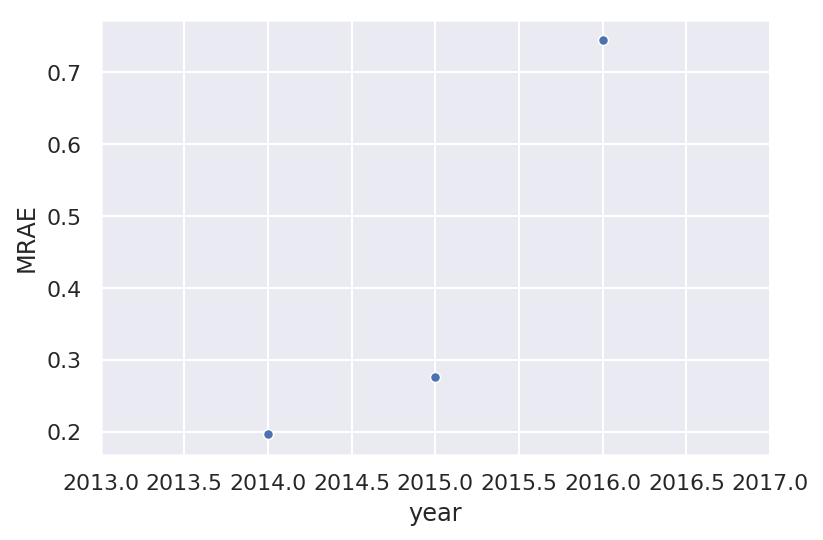

In [46]:
####plot
sns.scatterplot([2014.0,2015.0,2016.0], MRAE_year,s=25)
plt.xlim(2013,2017)
plt.xlabel('year')
plt.ylabel('MRAE')
plt.title('MRAE vs. year, data fitted within the year')

Text(0, 0.5, 'MRAE')

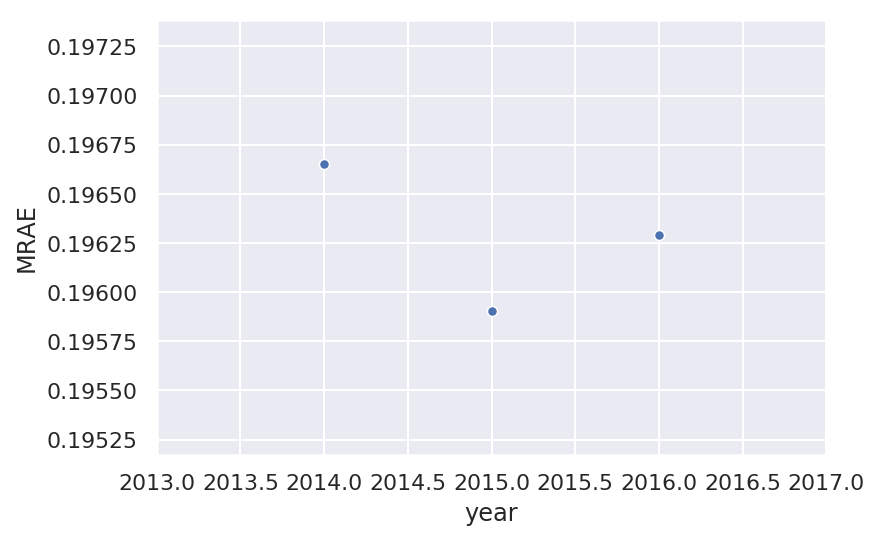

In [47]:
# we use <= year instead of = year
df2_year = []
df2_X_year = []
df2_y_year = []
for year in range(2014,2017):
  df_temp_year = df2[df2['year'] <= year]  # change here
  df2_year.append(df_temp_year)
  df2_X_year.append(df_temp_year[['latitude','longitude','close_date']])
  df2_y_year.append(df_temp_year['close_price'])
  
  
  
X_year = []
y_year = []
for i in range(len(df2_X_year)):
  dfX = df2_X_year[i]
  dfy = df2_y_year[i]
  X_year.append(dfX.values)
  y_year.append(dfy.values)
  
  
knn = Model_2_KNN(k =4, weights = 'distance',p=2)
MRAE_year = []
for i in range(len(X_year)):
  X = X_year[i]
  y = y_year[i]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  MRAE_year.append(np.median(np.abs(y_pred - y_test) / y_test))
  

sns.scatterplot([2014.0,2015.0,2016.0], MRAE_year,s=25)
plt.xlim(2013,2017)
plt.xlabel('year')
plt.ylabel('MRAE')
  

  


Spatial trends:
we choose four spaces ( LON,  LAT>0 ;  LON, LAT<0: LON>0, LAT<0 ; LON<0, LAT>0). The sample size are very different. So the MRAE will be different. The bigger sample size, the samller error. 


In [55]:
# check LON>0, LAT>0 ;  LON, LAT<0: LON>0, LAT<0 ; LON<0, LAT>0

df1_space = [df1[(df1['latitude']>0) & (df1['longitude']>0)], df1[(df1['latitude']<=0) & (df1['longitude']>0)],df1[(df1['latitude']>0) & (df1['longitude']<=0)],df1[(df1['latitude']<0) & (df1['longitude']<0)]]
for f in df1_space:
  print(len(f))

1026
1083
82717
1042


In [0]:
df1_space_X = []
df1_space_y = []
for f in df1_space:
  df1_space_X.append(f[['latitude','longitude','close_date']])
  df1_space_y.append(f['close_price'])

X_space = []
y_space = []
for i in range(len(df1_space_X)):
  dfX = df1_space_X[i]
  dfy = df1_space_y[i]
  X_space.append(dfX.values)
  y_space.append(dfy.values)


In [0]:
knn = Model_2_KNN(k =4, weights = 'distance',p=2)
MRAE_space = []
for i in range(len(X_space)):
  X = X_space[i]
  y = y_space[i]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  MRAE_space.append(np.median(np.abs(y_pred - y_test) / y_test))

Text(0, 0.5, 'MRAE')

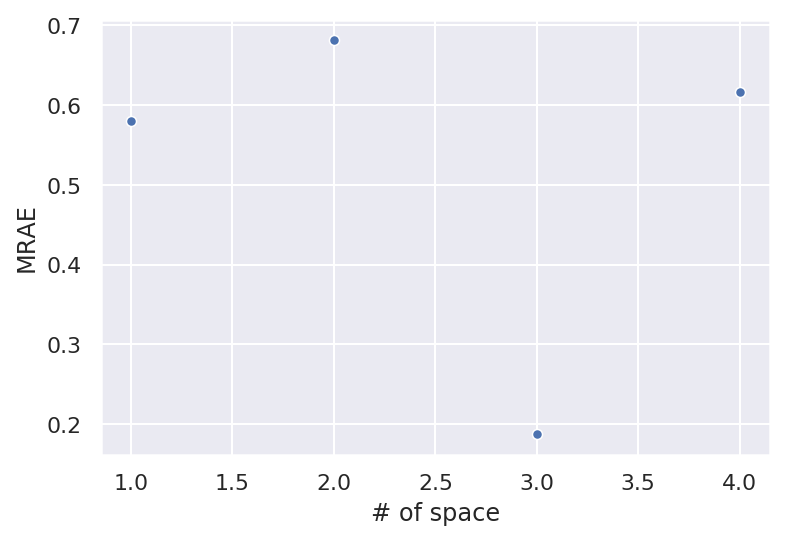

In [60]:
sns.scatterplot([1,2,3,4], MRAE_space,s=25)

plt.xlabel('# of space')
plt.ylabel('MRAE')

Improve and productionize the Model
---


Here we provide Model1 and Model2. The model 1 need calculate scan all the train sets, calculate all the distance/weights and find the nearest K neighbors without time leakage.  The model 2 improved by pre-select the train sets without time leakage (that save time comparing to model 1) and implement the SKlearn build-in KNNregressor. 

To improve from these two, I propse a model 3. These two models are not effective since they scan all the train space. We can just start from the training sample's location and expore the nearby samples without time leakage. In this way, we don't need to scan all the train space  (\~ O(n))  and just need check the nearby sample space  (\~ O(k)). This method needs some pre-sort (for example, use LON and LAT as index directly and sort/search nearby). 

To futhur improve and productionize the model, we need more features and also improve the weights calculation. The real house price will be a function of ecomomics and that is a function of time. We need consider the time into the weights. 
The zip code/ city will be a much better location metric instead of LON and LAT. The other house features like local school ratings, number of bedrooms, number of bathrooms, size and bulit year will be great in real production model.

As KNN is very sensitive to outliers, how to dectect and deal with outliers will be another challenge. In this takehome, I already delect the easy outliers manuuly (the negetive house price samples). 

Also in the production model, we can update the model everytime there is new data come in. The model will be dynamic and more accurate, also save time. For different regions, we can also use different K to make the model more effective and more accurate. 

---
Other exploration
---




---

delete the outliers





from the sample statistics, we notice the super high price houses might be a outlier. We mannully delete it and the MRAE become better (0.167). 

In [63]:
df1[df1['close_price']>100000000].describe()


,latitude,longitude,close_price
count,2137.000000,2137.000000,2.137000e+03
mean,34.511030,-93.491039,1.005054e+08
std,14.616984,31.427515,2.895800e+05
min,-89.161126,-176.920882,1.000014e+08
25%,36.198233,-98.496780,1.002598e+08
50%,36.381663,-98.168964,1.005039e+08
75%,36.546416,-97.971080,1.007602e+08
max,88.741500,174.504386,1.009998e+08


there are 2000 samples price > 1e8 and variation is very small. 

In [64]:
df3 = df1[df1['close_price']<100000000]
print(len(df3))

83731


In [0]:
df3_X = df3[['latitude','longitude','close_date']]
df3_y = df3['close_price']

X = df3_X.values
y = df3_y.values

t_ratio = 0.25 # test, traing ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = t_ratio)



In [0]:
knn = Model_2_KNN(k =4, weights = 'distance',p=2)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [67]:
MRAE = np.median(np.abs(y_pred - y_test) / y_test)
MRAE

0.1672090280043728



---

Combine it with k=1. 

In [0]:
knn1 = Model_2_KNN(k =1, weights = 'distance',p=2)
knn1.fit(X_train,y_train)
y_pred = knn1.predict(X_test)

In [76]:
MRAE = np.median(np.abs(y_pred - y_test) / y_test)
MRAE

0.1863075224624457